# Discovery of Optimal Quadrature Rules in Spline Spaces

In this notebook you can find some illustrative examples on how to use the method for discovering optimal quadrature rules described in the paper: *T. Teijeiro, A. Hashemian, J.M. Taylor and D. Pardo*, **Machine Learning Discovery of Optimal Quadrature Rules for Isogeometric Analysis**, 2023.

The full implementation of the method is available in the [`splinequadrature.py`](splinequadrature.py) module, and here we will rely on that functionality to show some examples of usage.

Let's start with some general imports:

In [1]:
import jax
import jax.numpy as jnp
#All calculations are done in double precision
jax.config.update("jax_enable_x64", True)

import numpy as np
from splinequadrature import (splinesbfns, Constants, get_optimizer, fit_quadrature_rule, 
                              initialize_uniform, initialize_nonuniform)

import matplotlib.pyplot as plt

## 1. Calculating a quadrature rule on a space with uniform elements

The first thing we need to do is to define our target space of basis functions. As an example, this will have degree 6, continuity 2, and 12 elements. We create it following the notation from the paper, and visualize all the basis functions:

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


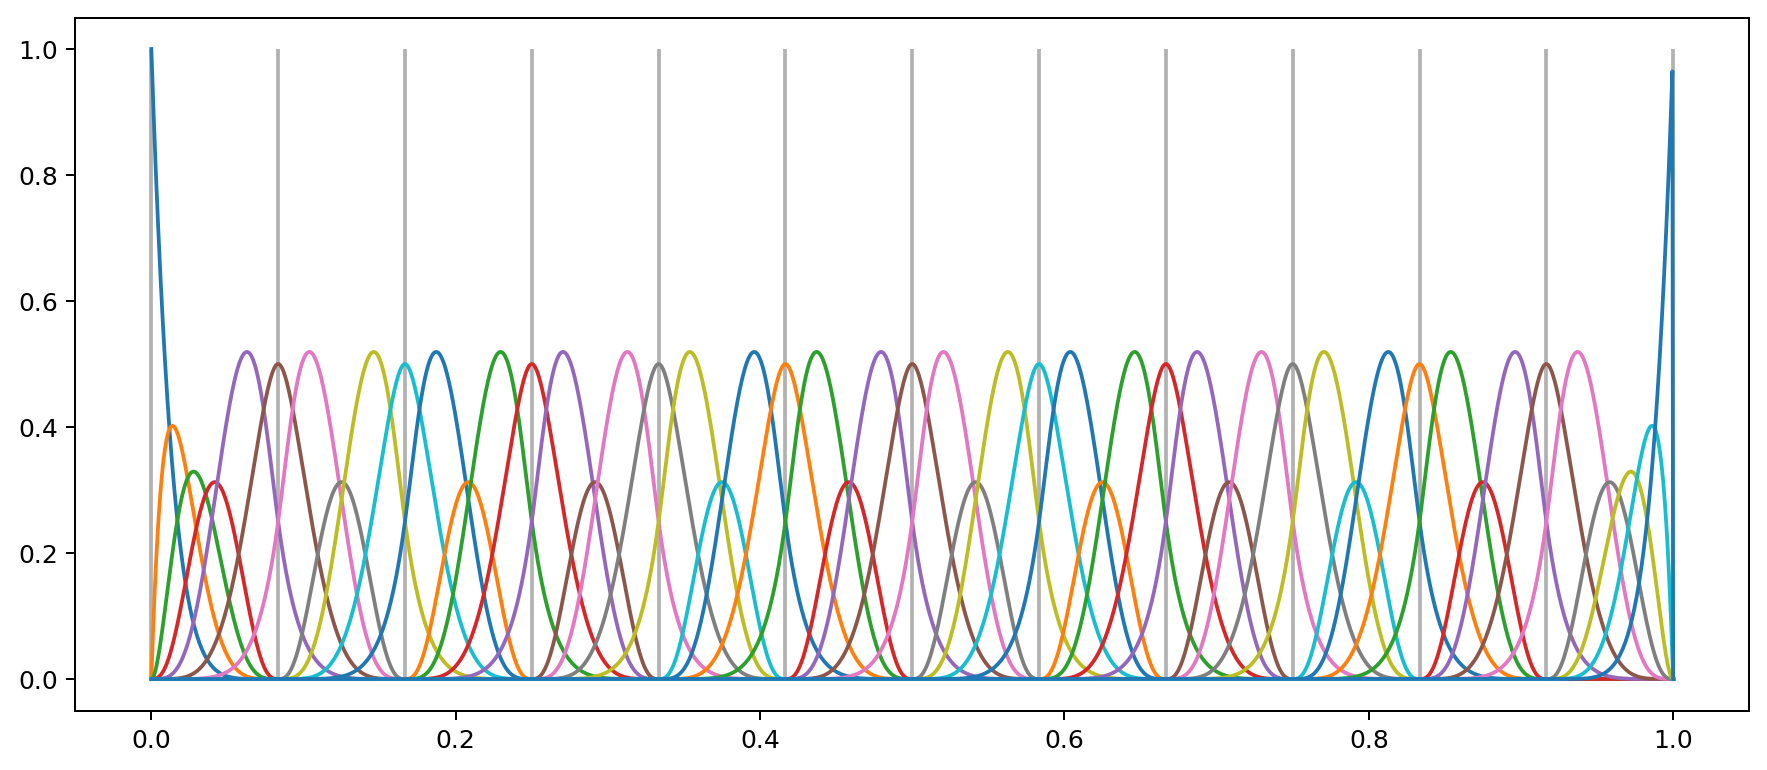

In [2]:
d = 6
k = 2
n_e = 12
partition = jnp.linspace(0, 1, n_e+1)
basis = jax.jit(splinesbfns(d, partition, k))
X = jnp.linspace(0, 1, 2000)
fig = plt.figure(figsize=(12, 5), dpi=180)
plt.vlines(partition, 0, 1, alpha=0.3, color='k')
_ = plt.plot(X, basis(X).T)

In order to run the optimization method, we first need to define the constants of the problem, and then initialize the parameters to optimize. As described in the paper, the initialization of the parameters is done from an optimal rule of a space with the same degree and continuity, but one fewer element. 

For this specific case, since we already have the rule precalculated in the `optimal_uniform_rules.csv` file, we can directly do this initialization. Otherwise, we need to implement the dynamic programming strategy in which we recursively solve problems with one fewer element to get the initialization. We show both cases below:

In [3]:
#Load pre-calculated quadrature rules
import pandas as pd
rules = pd.read_csv('optimal_uniform_rules.csv')
#Get the rule for the space with same degree and partition but one fewer element
rule = rules.query(f'd=={d} and k=={k} and n_e=={n_e-1}').iloc[0]

#Define the problem
C = Constants(basis, d, k, partition)
optimizer = get_optimizer(C)
init_x, init_w = initialize_uniform(d, k, n_e, jnp.array(eval(rule.x)), jnp.array(eval(rule.w)))
parameters = {'x':init_x, 'w':init_w}

Now we have all the necessary pieces to run the optimization algorithm:

In [4]:
final_params, loss, nepoc = fit_quadrature_rule(C, parameters, optimizer)
print(f'Solution found in {nepoc} iterations. Final error: {loss}')

Solution found in 527 iterations. Final error: 9.163641842067844e-26


In [5]:
#Measure of time required to calculate the quadrature rule
%timeit fit_quadrature_rule(C, parameters, optimizer)

595 ms ± 10.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


If we don't have the rule for the simpler space calculated, we need to do it recursively (or, in a more efficient way, iteratively):

In [6]:
from tqdm import trange
#Basic initialization for n_e=2
q = int(np.ceil((d+1+(d-k))/2.))
params = {'x': jnp.linspace(0, 1, q), 'w': jnp.ones(q)/q}
#Iterative solving for increasing number of elements
for n in trange(2, n_e):
    x1, w1 = params['x'], params['w']
    part = jnp.linspace(0, 1, n+1)
    basis = jax.jit(splinesbfns(d, part, k))
    init_x, init_w = initialize_uniform(d, k, n, x1, w1)
    initial_params = {'x':init_x, 'w':init_w}
    Cn = Constants(basis, d, k, partition)
    optimizer = get_optimizer(Cn)
    params, _, _ = fit_quadrature_rule(Cn, initial_params, optimizer)
#Now we can obtain the initialization for our target space
init_x, init_w = initialize_uniform(d, k, n_e, params['x'], params['w'])
parameters = {'x':init_x, 'w':init_w}
final_params, loss, nepoc = fit_quadrature_rule(C, parameters, optimizer)
print(f'Solution found in {nepoc} iterations. Final error: {loss}')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.44s/it]


Solution found in 531 iterations. Final error: 9.680129816319657e-26


Now we will visualize the quadrature rule, by displaying the obtained points and weights as circles over the basis functions. The area of each circle is proportional to the weight of the corresponding point.

In [7]:
def plot_quadrature_rule(constants, x, w):
    """
    Makes a plot to visualize a quadrature rule.
    """
    fig = plt.figure(figsize=(12, 5), dpi=180)
    X = np.linspace(0, 1, 2000)
    plt.plot(X, constants.basis(X).T, alpha=0.2)
    draw = plt.scatter(x, np.zeros_like(x), alpha=0.4)
    draw.set_sizes(10000*w)
    plt.xlim((-0.02, 1.02))
    plt.ylim((-0.25, 1.25))
    plt.xticks(constants.partition)
    plt.grid()
    return fig

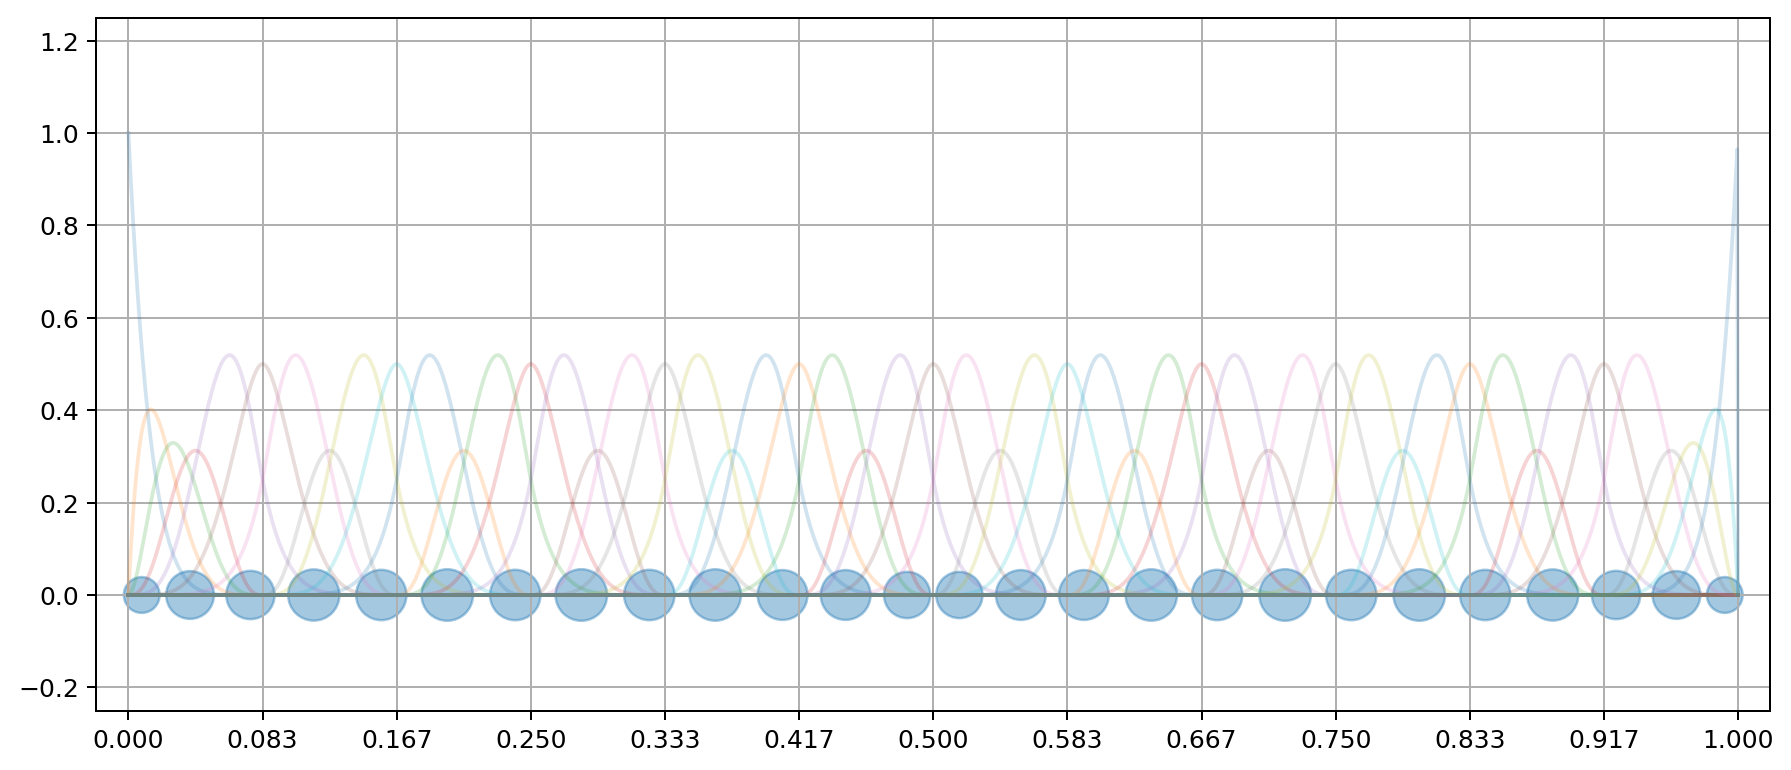

In [8]:
fig = plot_quadrature_rule(C, final_params['x'], final_params['w'])

## 2. Calculating a quadrature rule on a space with non-uniform elements

Our next example shows how to calculate the rule for a space with non-uniform elements. First we create a random partition, with the same number of elements than the space with uniform elements:

In [9]:
np.random.seed(5)
partition_nunif = np.concatenate(([0.], np.sort(np.random.rand(n_e-1)), [1.]))

Now we create the basis functions and we visualize the space:

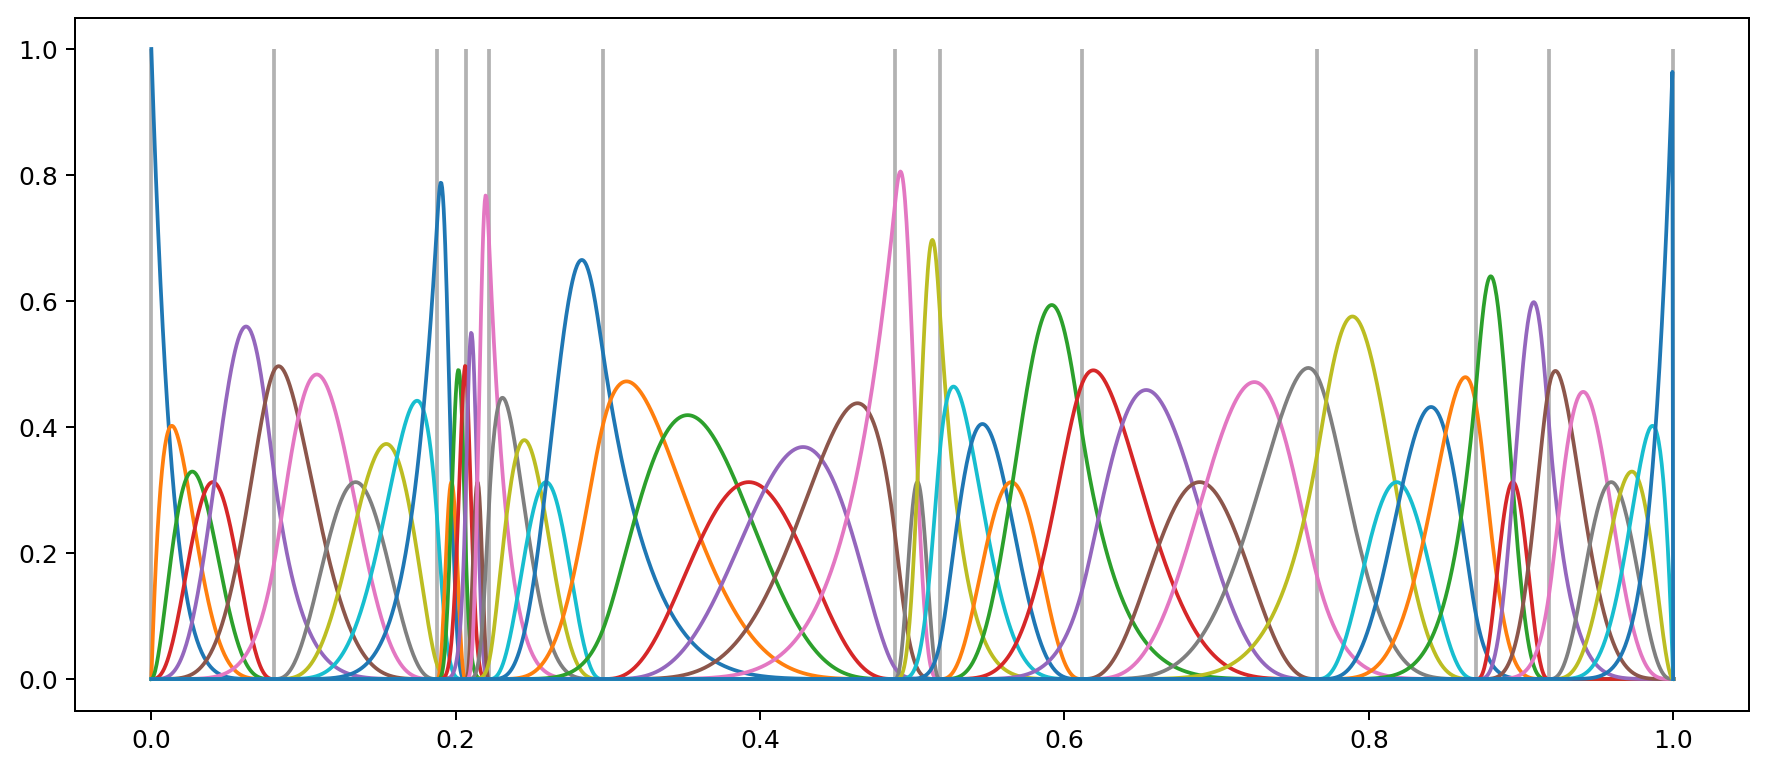

In [10]:
basis_nunif = jax.jit(splinesbfns(d, partition_nunif, k))
X = jnp.linspace(0, 1, 2000)
fig = plt.figure(figsize=(12, 5), dpi=180)
plt.vlines(partition_nunif, 0, 1, alpha=0.3, color='k')
_ = plt.plot(X, basis_nunif(X).T)

The problem is defined in the same way than for uniform partitions, but the initialization has to be done from the solution with the same degree, continuity, number of elements, and with uniform elements (precisely the rule we just calculated!):

Solution found in 531 iterations. Final error: 9.680129816319657e-26


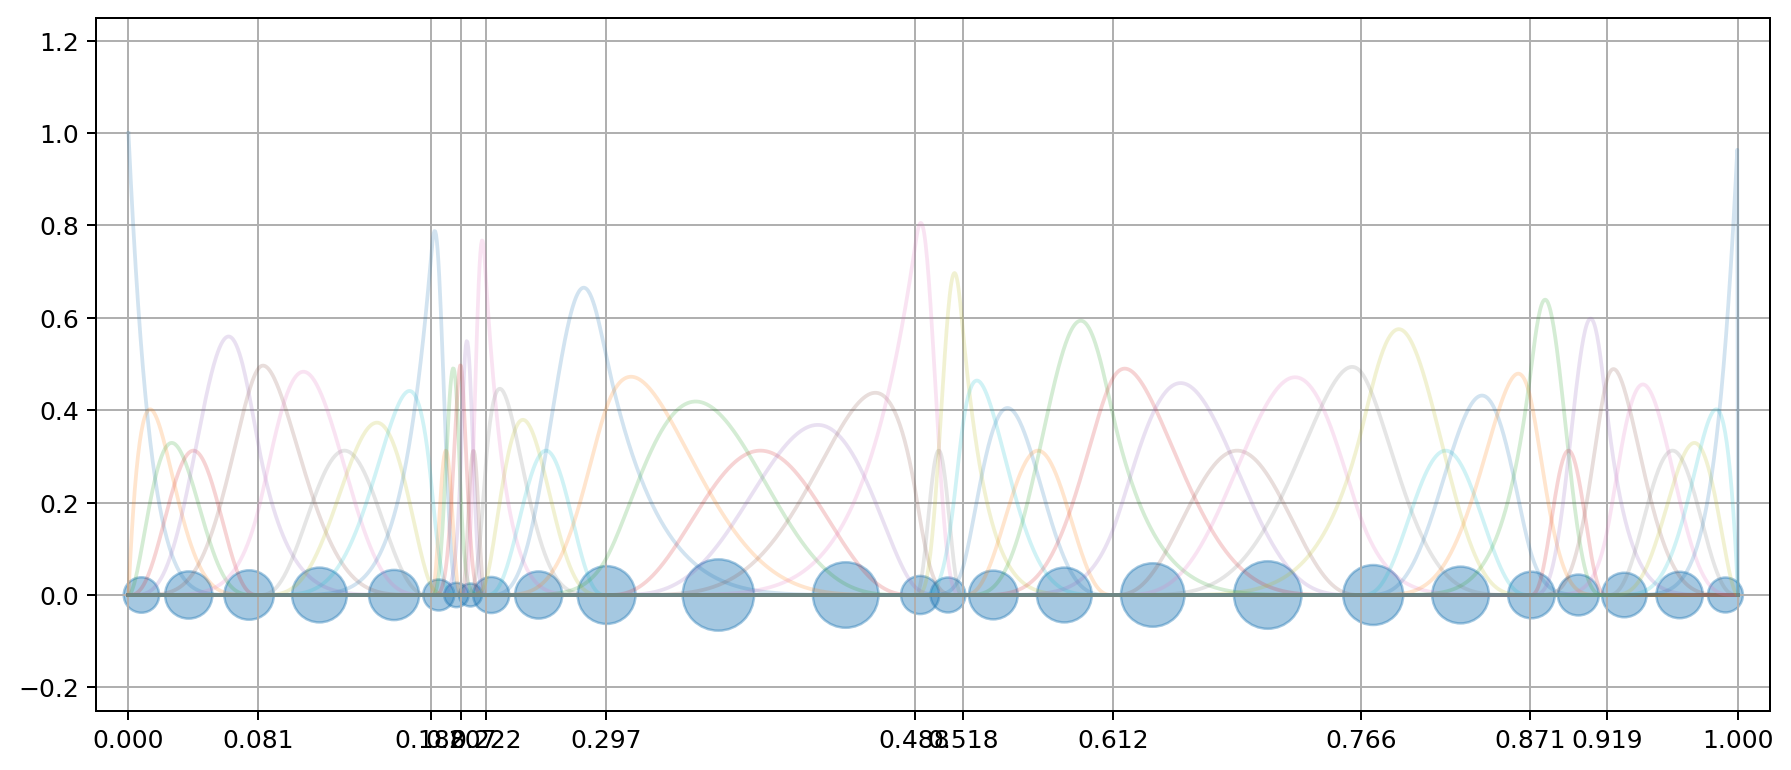

In [11]:
#Define the problem
C_nunif = Constants(basis_nunif, d, k, partition_nunif)
optimizer = get_optimizer(C_nunif)
init_x, init_w = initialize_nonuniform(partition_nunif, final_params['x'], final_params['w'])
parameters_nunif = {'x':init_x, 'w':init_w}

#Run the optimization
final_params_nunif, loss_nunif, nepoc_nunif = fit_quadrature_rule(C_nunif, parameters_nunif, optimizer)
print(f'Solution found in {nepoc} iterations. Final error: {loss}')
fig = plot_quadrature_rule(C_nunif, final_params_nunif['x'], final_params_nunif['w'])